# Рубежный контроль 1
+ Исполнитель: студент группы **ИУ5-65 Кириллов Денис**.
+ Вариант: **8**.

    <table>
    <tr>
    <td>Номер варианта</td>
    <td>Номер задачи</td>
    <td>Номер набора данных, указанного в задаче</td>
    </tr>
    <tr>
    <td>8</td>
    <td>1</td>
    <td>8</td>
    </tr>
    </table>


+ Дополнительное требование для группы **ИУ5-65**:

    Для студентов группы ИУ5-65Б - для набора данных **построить "парные диаграммы"**.

# Задача-1.

Для [заданного набора данных](https://www.kaggle.com/datasets/lava18/google-play-store-apps) проведите корреляционный анализ. В случае наличия пропусков в данных удалите строки или колонки, содержащие пропуски. Сделайте выводы о возможности построения моделей машинного обучения и о возможном вкладе признаков в модель.

In [263]:
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [264]:
%matplotlib inline 
sns.set(style="ticks")

# Открою датасет
data = pd.read_csv('./googleplaystore.csv', sep=",")
# характеристики
print("размер:", data.shape)
print("\nколонки:\n", data.dtypes)
data.head()

размер: (10841, 13)

колонки:
 App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Восстановление пропусков
Проверю на пропуски

In [265]:
print("\nПропущенные значения, %:")
for index, value in data.isnull().sum().get(lambda x: x > 0).items():
  print("{:25s} {: ^10} {:>10.3f}%\t{:s}".format(index, value, value*100/data.shape[0], str(data[index].dtype)))


Пропущенные значения, %:
Rating                       1474        13.597%	float64
Type                          1           0.009%	object
Content Rating                1           0.009%	object
Current Ver                   8           0.074%	object
Android Ver                   3           0.028%	object


Rating подделывать нет смысла. Удалю те строки, где он не указан, но оценка может быть нулем. Нужно удалить только Not A Number:

In [266]:
print("\nПропущенные значения в колонке Rating, %:")
missing_rating_values_cnt = data['Rating'].isna().sum()
print("{:25s} {: ^10} {:>10.3f}%".format('Rating', missing_rating_values_cnt, missing_rating_values_cnt*100/data['Rating'].shape[0]))


Пропущенные значения в колонке Rating, %:
Rating                       1474        13.597%


In [267]:
data = data.dropna(subset='Rating', axis=0)
# проверяю, а остались ли еще пропуски в других колонках после удаления строк
print("\nПропущенные значения, %:")
for index, value in data.isnull().sum().get(lambda x: x > 0).items():
  print("{:25s} {: ^10} {:>10.3f}%\t{:s}".format(index, value, value*100/data.shape[0], str(data[index].dtype)))


Пропущенные значения, %:
Content Rating                1           0.011%	object
Current Ver                   4           0.043%	object
Android Ver                   3           0.032%	object


Задача значительно упростилась. Буду считать, что если версия не указана, значит, это версия 0.0.1. Заполню константой. Таких значений всего 0,043%, и гистограмма значительно не изменится.

In [268]:
num_score_imptr = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='0.0.1')
data["Current Ver"] = num_score_imptr.fit_transform(data[["Current Ver"]])
print(data['Current Ver'].isnull().sum())
print(data['Current Ver'].unique(), data['Current Ver'].unique().shape[0])

0
['1.0.0' '2.0.0' '1.2.4' ... '1.5.447' '1.0.612928' '0.3.4'] 2639


## Изменение типа
Видно, что все признаки кроме rating распознались как категориальные, что нужно исправить согласно анализу ниже:

### числовые
+ Reviews - это точно число.
+ Size - как строка не удобен для анализа. Скорее всего, много уникальных значений. Нужно перевести буквы К, М, G в множители.
+ Price - точно число. Стереть символ доллара, представить как float.
+ Last Updated - это дата. Удобно представлять числом единиц времени с начала эпохи (дней, часов, микросекунд).
+ Current Ver - число из трех цифр, кроме строки "Varies with device", которую можно представить специальным значением -1.

### категориальные
+ Category, Installs, Content Rating, Genres, Android Ver - точно категориальные
+ Type - бинарная классификация
+ App - перекодировать бессмысленно: слишком велико число уникальных: 9660 из 10841.

### Изменение типа: кодирование категориальных признаков числами.

In [269]:
cat_cols_list = ['Category', 'Installs', 'Content Rating', 'Genres', 'Android Ver', 'Type']

Трансформирую те признаки, которые я точно признаю категориальными в числовые с помощью label encoder 

In [270]:
# сохраню возможность декодирования сюда
cat_names_decoding_map = dict()

for cat in cat_cols_list:
  print(data[cat].shape[0], '>>', data[cat].unique().shape[0], '? ->', data[cat].shape[0] > data[cat].unique().shape[0])
  le = LabelEncoder()
  lables = le.fit_transform(data[cat])
  data[cat] = le.transform(data[cat])
  cat_names_decoding_map[cat] = {
    'encoder': le,
    'lables': lables,
  }

print(data[cat_cols_list].dtypes)

9367 >> 34 ? -> True
9367 >> 20 ? -> True
9367 >> 7 ? -> True
9367 >> 116 ? -> True
9367 >> 32 ? -> True
9367 >> 3 ? -> True
Category          int32
Installs          int32
Content Rating    int32
Genres            int32
Android Ver       int32
Type              int32
dtype: object


### Изменение типа: приведение псевдокатегориаьных признаков к числовому формату.

Эсперимантальным путем (страданий) было выяснено следующее: 

В Size встречаются записи вида:
+ 619k
+ 0M
+ 0G
+ 1.7M

В Price встречаются записи вида:
+ $0.0
+ 0
+ "Everything"

В Cur Ver:
+ 1.9.1
+ 1.7
+ 2.20 Build 02
+ 1.6.798986
+ Public.Heal
+ 3.0.1.11 (Build 311)
+ "Varies with device"

В Reviews:
+ 100
+ 1.0M

In [271]:
err_print = False


size_literal_map = {
  'K': 1,
  'M': 1000,
  'G': 1000000,
  'k': 1,
  'm': 1000,
  'g': 1000000,
}

def size_transformer_worker(el):
  if not re.match(r'^\d+(\.\d+)?[M|G|K|m|g|k]$', el) or el == "Varies with device":
    if err_print: print('error on', el)
    return -1
  num = re.search(r'^\d+(\.\d+)?', el)
  letter = re.search(r'[M|G|K|g|m|k]$', el)
  return float(num.group(0)) * size_literal_map[letter.group(0)]

def size_transformer(arr):
  return pd.to_numeric([size_transformer_worker(el) for el in arr])
    
def price_transformer_worker(el):
  if el == '0':
    return 0
  if not re.match(r'^\$\d+(\.\d+)?$', el):
    if err_print: print('error on', el)
    return -1
  return el.replace('$', '')

def price_transformer(arr):
  return pd.to_numeric([price_transformer_worker(el) for el in arr])
    
# декодировать все это - сущее мучение. С датой хуже всего
def updated_transformer(arr):
  print()

def version_transformer_worker(el):
  if el == 'Varies with device':
    return -1
  z =  re.split(r'\D+', el)
  for i, ch in enumerate(z):
    if ch == '':
      z[i] = 0
    else:
      z[i] = int(ch) 
  if len(z) == 0:
    if err_print: print('error on', el)
    return 1
  if len(z) == 1:
    return float(z[0])
  if len(z) == 2:
    return z[0] + z[1] / 100
    
  return z[0] * 10 + z[1] + z[2] / 100
  # return float("".join(z[:len(z)-1]).join(('.', z[len(z)-1])))

def version_transformer(arr):
  return pd.to_numeric([version_transformer_worker(el) for el in arr])

pseudo_categorial_dict = [
  ('Size', size_transformer),
  ('Price', price_transformer),
  ('Last Updated', updated_transformer),
  ('Current Ver', version_transformer),
  ('Reviews', size_transformer) # lambda x: pd.to_numeric(x))  # не подошел (
]


In [272]:
for cat, method in pseudo_categorial_dict:
  print(cat)
  data[cat] = method(data[cat])

Size
Price
Last Updated

Current Ver
Reviews


In [273]:
print(data.dtypes)

App                object
Category            int32
Rating            float64
Reviews             int64
Size              float64
Installs            int32
Type                int32
Price             float64
Content Rating      int32
Genres              int32
Last Updated       object
Current Ver       float64
Android Ver         int32
dtype: object


Мне удалось преобразовать все эти разнообразные форматы в числа для дальнейшего анализа.

Было потрачено слишком много времени на преведение всевозможных форматов строк к числам. С датами я этим заниматься не буду. Для исследований, она наименее полезна.

## Матрица корреляций

C:\Users\dturc\AppData\Local\Temp\ipykernel_13560\3470817974.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(data.corr(), dtype=np.bool)


<AxesSubplot:>

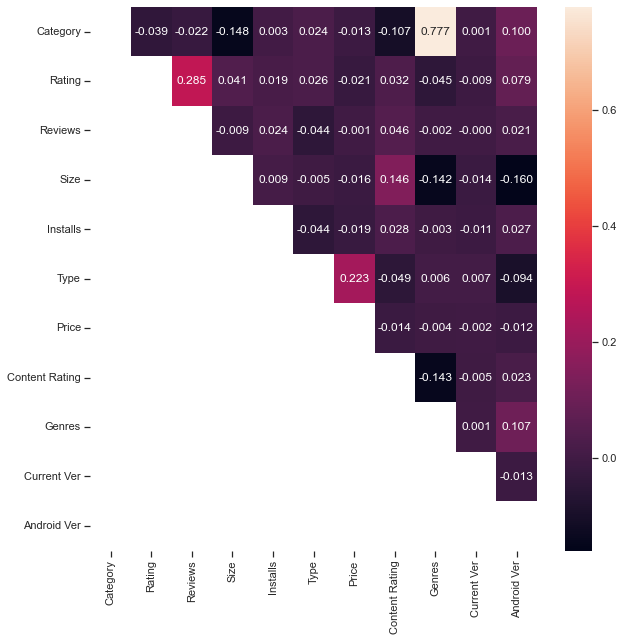

In [274]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,10))

# Треугольный вариант матрицы
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.tril_indices_from(mask)] = True
sns.heatmap(data.corr(), mask=mask, annot=True, fmt='.3f')

## Вывод

Это ужастный датасет как в плане очищения данных, так и по связанности признаков.

Коррелируют только 2: **Category** и **Genres**.
Слабая корреляция присутствует у признаков **Rating** и **Reviews**, по чему можно сделать вывод, что большинство людей склоны завышать оценки.
Слабая корреляция также наблюдается у признаков **Type** и **Price**, что очевидно, потому что у всех приложений с price = 0, стоит type=free, так что эта информация не имеет никакой ценности для исследования.